In [2]:
from datasets import BitcoinOTC, BitcoinAlpha, AS733, UCIMessage
from dataloader import BitcoinLoaderFactory
import matplotlib.pyplot as plt
import seaborn as sbn
from tqdm import tqdm
import torch
import os
import numpy as np
import pandas as pd
from torch_geometric.datasets import JODIEDataset

datasets = []

datasets.append(BitcoinOTC('./data/bitcoin', transform=None))
datasets.append(AS733('./data/as-733', transform=None))
datasets.append(BitcoinAlpha('./data/bitcoin', transform=None))
datasets.append(UCIMessage('./data/uci-msg', transform=None))

root = '/home/qqg/data/pyg/JODIE'
datasets.append(JODIEDataset(root, 'reddit'))
datasets.append(JODIEDataset(root, 'wikipedia'))
datasets.append(JODIEDataset(root, 'mooc'))
datasets.append(JODIEDataset(root, 'lastfm'))

datanames = [
    'bitcoinotc', 'as733', 'bitcoinalpha', 'uci', 
    'reddit', 'wikipedia', 'mooc', 'lastfm', 
]

<Axes: >

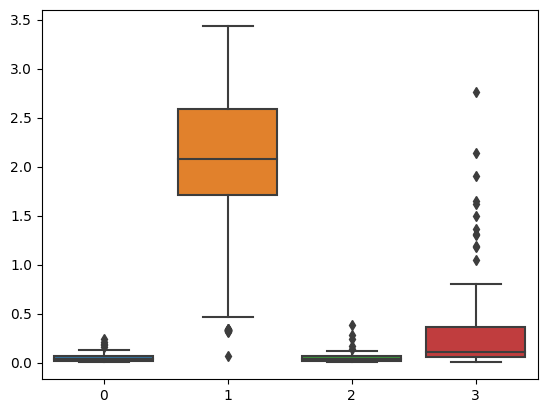

In [4]:
ratio = []
for ds in datasets[:4]:
    r = []
    for d in ds:
        r.append( len(d.edge_attr) / d.num_nodes )
    ratio.append(r)

sbn.boxplot(ratio)

In [100]:
import os

class ParseExperimentLog():
    def __init__(self):
        pass

    def parse_line(self, line, pos):
        return line.strip().split(' ')[pos]

    def read_file(self, file_path):
        with open(file_path, 'r') as f:
            lines = f.readlines()
            if len(lines) > 44:
                lines = lines[-44:]
            ds = self.parse_line(lines[1], -1)
            model = self.parse_line(lines[2], -1)
            if model == 'roland':
                is_meta = self.parse_line(lines[25], -1)
                if is_meta == 'True':
                    model = 'roland_meta'
            gpu_mem = float(self.parse_line(lines[30], -2))
            epoch_time = float(self.parse_line(lines[32], -2))
            train_time = float(self.parse_line(lines[33], -2))
            mean = [float(x.strip()) for x in lines[41].split('|')[3:7]]
            std  = [float(x.strip()) for x in lines[42].split('|')[3:7]]
            return {
                'dataset': ds,
                'model': model,
                'gpu_mem': gpu_mem,
                'epoch_time': epoch_time,
                'train_time': train_time,
                'mrr_mean': mean[0],
                'hit@1_mean': mean[1],
                'hit@3_mean': mean[2],
                'hit@10_mean': mean[3],
                'mrr_std': std[0],
                'hit@1_std': std[1],
                'hit@3_std': std[2],
                'hit@10_std': std[3],
            }
    
    def read_all(self, log_path='log'):
        records = []
        for file in os.listdir(log_path): 
            if file.endswith(".log"): 
                file_path = f"log/{file}"
                records.append(self.read_file(file_path))
        return pd.DataFrame(records)

parser = ParseExperimentLog()
df = parser.read_all()

In [101]:
df

,dataset,model,gpu_mem,epoch_time,train_time,mrr_mean,hit@1_mean,hit@3_mean,hit@10_mean,mrr_std,hit@1_std,hit@3_std,hit@10_std
0,bitcoinotc,hgat,1286.71,3.80,22.78,0.1588,0.0724,0.1793,0.3634,0.0003,0.0004,0.0020,0.0020
1,bitcoinalpha,vgrnn,4777.18,4.31,51.74,0.0155,0.0023,0.0091,0.0311,0.0005,0.0000,0.0019,0.0043
2,bitcoinotc,gcn,1243.67,3.02,21.17,0.1401,0.0579,0.1442,0.3292,0.0002,0.0008,0.0008,0.0008
3,bitcoinalpha,roland,4669.08,0.01,0.09,0.0697,0.0197,0.0607,0.1769,0.0021,0.0021,0.0028,0.0120
4,as733,roland,26168.48,1.55,9.79,0.2733,0.2035,0.2798,0.3986,0.0077,0.0136,0.0073,0.0473
5,uci,roland_meta,4752.03,0.02,1.51,0.0815,0.0256,0.0718,0.1856,0.0069,0.0032,0.0121,0.0109
6,bitcoinotc,roland_meta,4947.83,0.02,0.17,0.1053,0.0361,0.1009,0.2666,0.0112,0.0097,0.0157,0.0137
7,as733,vgrnn,25991.67,84.87,1103.26,0.1210,0.0654,0.1219,0.2275,0.0055,0.0033,0.0067,0.0121
8,as733,evolve-o,8807.49,132.40,4104.46,0.1132,0.0619,0.1137,0.2075,0.0035,0.0023,0.0042,0.0065
9,uci,roland,4747.19,0.02,1.87,0.0857,0.0292,0.0768,0.1917,0.0102,0.0108,0.0077,0.0192


/home/qqg/miniconda3/envs/zoo/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/qqg/miniconda3/envs/zoo/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


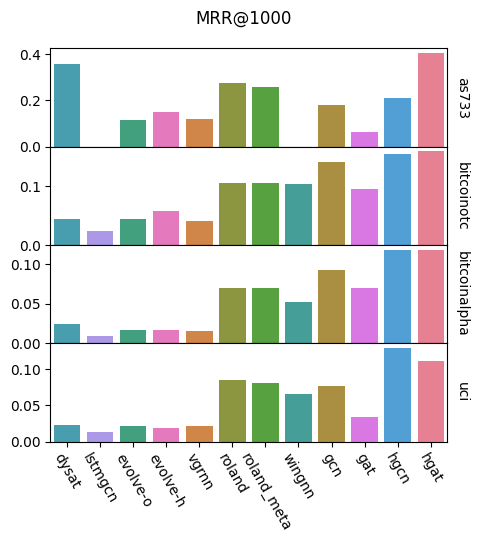

In [108]:
hue_order = [
    'dysat', 'lstmgcn', 'evolve-o', 'evolve-h', 'vgrnn', 'roland', 'roland_meta', 'wingnn',
    'gcn', 'gat', 'hgcn', 'hgat',  
]
row_order = ['as733','bitcoinotc', 'bitcoinalpha', 'uci']
g1 = sbn.FacetGrid(df, row="dataset", sharey=False, sharex=False, hue='model', 
                  aspect=4, height=1.2, margin_titles=True, despine=False, row_order=row_order)
g1.map_dataframe(sbn.barplot, x="model", y="mrr_mean", order=hue_order)

for i, axes in enumerate(g1.axes.flat):
    axes.set_ylabel('')
    if i+1 < df.dataset.nunique():
        axes.set_xticklabels([])
    else:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=-60)
g1.set_titles(col_template="{col_name}", row_template="{row_name}")
#g1.set_ylabels("MRR@1000")
g1.figure.subplots_adjust(wspace=0, hspace=0)
g1.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g1.fig.suptitle('MRR@1000')
g1.set_xlabels("")

/home/qqg/miniconda3/envs/zoo/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/qqg/miniconda3/envs/zoo/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


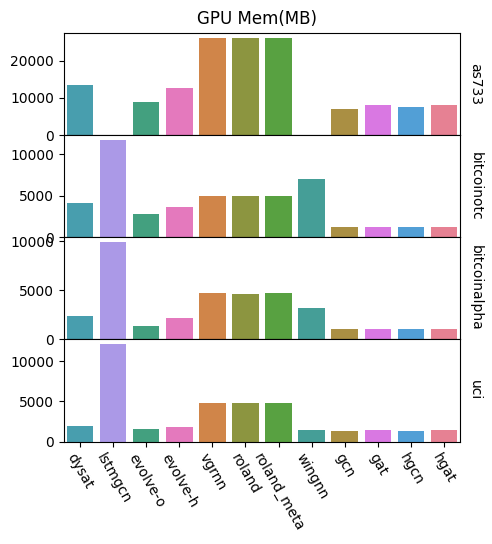

In [111]:

g1 = sbn.FacetGrid(df, row="dataset", sharey=False, sharex=False, hue='model', 
                  aspect=4, height=1.2, margin_titles=True, despine=False, row_order=row_order)
g1.map_dataframe(sbn.barplot, x="model", y="gpu_mem", order=hue_order)

for i, axes in enumerate(g1.axes.flat):
    axes.set_ylabel('')
    if i+1 < df.dataset.nunique():
        axes.set_xticklabels([])
    else:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=-60)
g1.set_titles(col_template="{col_name}", row_template="{row_name}")
#g1.set_ylabels("GPU Mem(M)")
g1.fig.suptitle('GPU Mem(MB)')
g1.figure.subplots_adjust(wspace=0, hspace=0)
g1.set_xlabels("")

In [114]:
sum([d.edge_index.size(1) for d in datasets[1][:100]])

1167892

In [116]:
datasets[1][0]

Data(edge_index=[2, 10695], edge_attr=[10695, 1], num_nodes=7716)